In [1]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/lib/python3.8/site-packages/'))
sys.path.insert(0,os.path.join('/venv/lib/python3.8/site-packages'))

def ignore_user_installs(username):
    ## avoid using user installs
    user_install_path = '/scratch/' + username + '/python/lib/python3.8/site-packages'
    if user_install_path in sys.path:
        sys.path.remove(user_install_path)

ignore_user_installs("starzew")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import dill
from scipy.stats import rankdata, kendalltau
from matplotlib.lines import Line2D

In [3]:
def load_pkl(file_name):
    with open(file_name, 'rb') as inp:
        data = dill.load(inp)
        
    return data

In [ ]:
def plot_sims_both(sims_embs, sims_atts, severities, title):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(4,2, sharey="row",sharex="col")
    fig.set_figwidth(480*px)
    fig.set_figheight(5)
    fs = 13
    
    
    y = ["Cosine", "CKA", "PWCCA", "SVCCA"]

    for i,sim in enumerate(sims_embs):
        for sev in severities:
            ax[i][0].plot(np.diagonal(sims_embs[i][sev]), label=sev)
            ax[i][1].plot(range(1,7),np.diagonal(sims_atts[i][sev]), label=sev)

        ax[i][0].set_ylabel(y[i], fontsize=fs)
        if i == 0:
            handles, labels = ax[i][0].get_legend_handles_labels()
            ax[i][0].set_title("Embeddings", fontsize=fs)
            ax[i][1].set_title("Attentions", fontsize=fs)
        if i == 3:
            ax[i][0].set_xlabel("Layer", fontsize=fs)
            ax[i][1].set_xlabel("Layer", fontsize=fs)
        ax[i][0].tick_params(axis='both', which='major', labelsize=fs-2)
        ax[i][1].tick_params(axis='both', which='major', labelsize=fs-2)


    plt.figlegend(handles,labels,fontsize=fs,loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=6)
    plt.subplots_adjust(hspace=0.15,wspace=0.1)
    fig.align_labels()
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [5]:
def plot_diffs_both(sims, severities, title, c,emb_att):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(4,2, sharey=False,sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(5)
    fs = 13
    if emb_att=="emb":
        valuerange = range(7)
    elif emb_att=="att":
        valuerange = range(1,7)
    
    y = ["Cosine", "CKA", "PWCCA", "SVCCA"]

    for i,sim in enumerate(sims):
        for sev in severities:
            if c:
                ax[i][0].plot(valuerange,np.diagonal(sim["c"])-np.diagonal(sim[sev]), label=sev)
                ax[i][1].plot(valuerange,np.diagonal(sim[sev])/np.diagonal(sim["c"]), label=sev)
            else:
                ax[i][0].plot(valuerange,np.diagonal(sim[f"{sev}_b"])-np.diagonal(sim[sev]), label=sev)
                ax[i][1].plot(valuerange,np.diagonal(sim[sev])/np.diagonal(sim[f"{sev}_b"]), label=sev)

        ax[i][0].tick_params(axis='both', which='major', labelsize=fs-3)
        ax[i][1].tick_params(axis='both', which='major', labelsize=fs-3)
        ax[i][0].set_ylabel(y[i], fontsize=fs)
        
        if i == 0:
            handles, labels = ax[i][0].get_legend_handles_labels()
            ax[i][0].set_title("Diff", fontsize=fs)
            ax[i][1].set_title("Rel", fontsize=fs)
            
        if i == 3:
            ax[i][0].set_xlabel("Layer", fontsize=fs)
            ax[i][1].set_xlabel("Layer", fontsize=fs)

    plt.subplots_adjust(hspace=0.15,wspace=0.25)
    fig.align_labels()
    plt.figlegend(handles,labels,fontsize=fs,loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=6)
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
def get_sev_diffs(n_layers, sims, baseline=False, c=False):
    metrics = ["Cosine", "CKA", "PWCCA", "SVCCA"]
    severities = ["v_l","l","m","h","all","c"]

    maxdiff = dict()
    i_max = dict()
    diffquot = dict()
    for sim, metric in zip(sims,metrics):

        maxdiff[metric] = []
        for i in range(n_layers):
            values = []
            for sev in severities:
                if baseline:
                    if c:
                        values.append(np.diagonal(sim[sev])/np.diagonal(sim["c"])[i])
                    else:
                        values.append(np.diagonal(sim[sev])/np.diagonal(sim[f"{sev}_b"])[i])
                else:
                    values.append(np.diagonal(sim[sev])[i])
            values = np.array(values)
            #print(values)
            maxdiff[metric].append(values.max()-values.min())

        maxdiff[metric]=np.array(maxdiff[metric])
        i_max[metric] = maxdiff[metric].argmax()
        diffquot[metric] = np.mean(np.diff(maxdiff[metric]))
        
    return maxdiff, i_max, diffquot


In [ ]:
def plot_kendalltaus_both(kendalltaus_emb,kendalltaus_att,title):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig,ax = plt.subplots(2,1,sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(3.5)
    fs = 13

    for metric in kendalltaus_emb:
        ax[0].plot(kendalltaus_emb[metric],label=f"{metric}")
        ax[0].set_title("Embeddings")
        h,l = ax[0].get_legend_handles_labels()
        
        ax[1].plot(range(1,7),kendalltaus_att[metric],label=f"{metric}" )
        ax[1].set_title("Attentions")
        
    for a in ax:
        a.tick_params(axis='both', which='major', labelsize=fs)

    plt.xlabel("Layer", fontsize=fs)
    plt.xticks(fontsize=fs)
    fig.supylabel("Kendall's Tau", fontsize=fs)
    plt.yticks(fontsize=fs)

    plt.figlegend(h,l,fontsize=fs,loc='upper center', bbox_to_anchor=(0.55, 1.15), ncols=4)
    plt.tight_layout()
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
def plot_kendalltaus_ptft_both(kendalltaus_emb_pt,kendalltaus_emb_ft,kendalltaus_att_pt,kendalltaus_att_ft, title):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig,ax = plt.subplots(2,1,sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(3.5)
    fs = 13

    for metric in kendalltaus_emb_pt:
        ax[0].plot(kendalltaus_emb_pt[metric],label=f"{metric} PT")
        ax[0].plot(kendalltaus_emb_ft[metric],label=f"{metric} FT",ls="dashed",lw=2)
        ax[0].set_title("Embeddings")
        h,l = ax[0].get_legend_handles_labels()
        
        ax[1].plot(range(1,7),kendalltaus_att_pt[metric],label=f"{metric} PT" )
        ax[1].plot(range(1,7),kendalltaus_att_pt[metric],label=f"{metric} FT",ls="dashed", lw=3 )
        ax[1].set_title("Attentions")
        
    for a in ax:
        a.tick_params(axis='both', which='major', labelsize=fs)

    plt.xlabel("Layer", fontsize=fs)
    plt.xticks(fontsize=fs)
    fig.supylabel("Kendall's Tau", fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.margins(y=0.2)

    plt.figlegend(h,l,fontsize=fs,loc='upper center', bbox_to_anchor=(0.55, 1.2), ncols=4)
    plt.tight_layout()
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
def get_diffquots(sims, baseline=False, c=False):
    diffs = dict()
    diffs_mean = dict()
    metrics = ["Cosine", "CKA", "PWCCA", "SVCCA"]
    for sim,metric in zip(sims,metrics):
        diffs[metric] = dict()
        sevs = ['v_l','l','m','h','all']
        for sev in sevs:
            if baseline:
                if c:
                    values = np.diagonal(sim[sev])/np.diagonal(sim["c"])
                else:
                    values = np.diagonal(sim[sev])/np.diagonal(sim[f"{sev}_b"])
            else:
                values = np.diagonal(sim[sev])
            diffs[metric][sev] =  np.diff(values)
                    

        diffs_mean[metric] = dict()
        for key in diffs[metric]:
            diffs_mean[metric][key] = np.mean(diffs[metric][key])
        diffs_mean[metric]["total"] = np.mean(list(diffs_mean[metric].values()))
       
    
    
    return diffs, diffs_mean

In [15]:
# calculate the kendall taus for all metrics and all layers
# baseline: whether the values need to be normalized with baseline
# c: whether the values are from "healthy vs dysarthric" experiment
def calc_kendalltaus(sims,metrics,n_layers,baseline=False,c=False):
    # extract sim values on diagonal of sim matrix
    values = {"Cosine":dict(), "CKA":dict(), "PWCCA":dict(), "SVCCA":dict()}
    for sim,metric in zip(sims,metrics):
        for layer in range(n_layers):
            values[metric][layer] = []
            for sev in ["v_l","l","m","h","c"]:
                if baseline:
                    if c:
                        values[metric][layer].append(np.diagonal(sim[sev])[layer]/np.diagonal(sim["c"])[layer])
                    else:
                        values[metric][layer].append(np.diagonal(sim[sev])[layer]/np.diagonal(sim[f"{sev}_b"])[layer])
                else:
                    values[metric][layer].append(np.diagonal(sim[sev])[layer])

                
    kendalltaus = dict()
    # original ranking of sevs
    og = [1,2,3,4,5]

    for metric in values:
        kendalltaus[metric] = []
        for layer in range(n_layers):
            # calc how much the rankings correlate
            kendalltaus[metric].append(kendalltau(rankdata(values[metric][layer]),og)[0])
            
    return kendalltaus

In [16]:
def plot_diff_quots_both(diffs_emb,diffs_mean_emb,diffs_att,diffs_mean_att, metrics,title):
    fig, ax = plt.subplots(2,2, sharex=True)
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig.set_figwidth(330*px)
    fig.set_figheight(4)
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

    ax = np.ndarray.flatten(np.array(ax))
    n_layers=7

    # plot diffquots
    for i,metric in enumerate(metrics):
        ax[i].plot(range(1,n_layers),diffs_emb[metric]["all"], label="Emb")
        ax[i].plot(range(2,n_layers),diffs_att[metric]["all"], label="Att")   
        ax[i].plot(range(1,n_layers),[0,0,0,0,0,0], color="red", lw=0.75)
        ax[i].set_title(metric)
        ax[i].set_box_aspect(1)
        ax[i].set_xticks(range(1,n_layers))

    h,l = ax[0].get_legend_handles_labels()

    for a in ax:
        a.set_prop_cycle(None)

    # plot mean diffquots
    for i,metric in enumerate(metrics):
        ax[i].plot(range(1,n_layers),np.repeat(diffs_mean_emb[metric]["all"],6), ls="dotted")
        ax[i].plot(range(2,n_layers),np.repeat(diffs_mean_att[metric]["all"],5), ls="dotted")

   
    fig.supxlabel("Layer", fontsize=fs, x=0.58, y=0.05)
    fig.supylabel("Difference Quotient", fontsize=fs, x=0.075,y=0.55)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2,hspace=0.3)

    plt.figlegend(h,l,fontsize=fs,loc='upper center', bbox_to_anchor=(0.58, 1.1), ncols=4)
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [19]:
def plot_diff_quots_ptft_both(diffs_emb_pt,diffs_emb_ft,diffs_att_pt,diffs_att_ft,diffs_mean_emb_pt,diffs_mean_emb_ft,diffs_mean_att_pt,diffs_mean_att_ft, metrics,title):
    fig, ax = plt.subplots(2,2, sharex=True)
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig.set_figwidth(330*px)
    fig.set_figheight(4)
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

    ax = np.ndarray.flatten(np.array(ax))
    n_layers=7

    # plot diffquots
    for i,metric in enumerate(metrics):
        ax[i].plot(range(1,n_layers),diffs_emb_pt[metric]["all"], label="Emb PT")
        ax[i].plot(range(1,n_layers),diffs_emb_ft[metric]["all"], label="Emb FT")
        ax[i].plot(range(1,n_layers),[0,0,0,0,0,0], color="red", lw=0.75)
        ax[i].plot(range(2,n_layers),diffs_att_pt[metric]["all"], label="Att PT")
        ax[i].plot(range(2,n_layers),diffs_att_ft[metric]["all"], label="Att FT")
        ax[i].set_title(metric)
        ax[i].set_box_aspect(1)
        ax[i].set_xticks(range(1,n_layers))

    h,l = ax[0].get_legend_handles_labels()

    for a in ax:
        a.set_prop_cycle(None)

    # plot mean diffquots
    for i,metric in enumerate(metrics):
        ax[i].plot(range(1,n_layers),np.repeat(diffs_mean_emb_pt[metric]["all"],6), ls="dotted")
        ax[i].plot(range(1,n_layers),np.repeat(diffs_mean_emb_ft[metric]["all"],6), ls="dotted")

        ax[i].plot(range(2,n_layers),np.repeat(diffs_mean_att_pt[metric]["all"],5), ls="dotted")
        ax[i].plot(range(2,n_layers),np.repeat(diffs_mean_att_ft[metric]["all"],5), ls="dotted")

    fig.supxlabel("Layer", fontsize=fs, x=0.58,y=0.05)
    fig.supylabel("Difference Quotient", fontsize=fs, x=0.075)

    plt.figlegend(h,l,fontsize=fs,loc='upper center', bbox_to_anchor=(0.58, 1.1), ncols=4, columnspacing=0.8)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0,hspace=0.3)
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [20]:
def plot_diff_quots_ptft_both2(diffs_emb_pt,diffs_emb_ft,diffs_att_pt,diffs_att_ft,diffs_mean_emb_pt,diffs_mean_emb_ft,diffs_mean_att_pt,diffs_mean_att_ft, metrics,title):
    fig, ax = plt.subplots(2,4, sharex=True)
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig.set_figwidth(480*px)
    fig.set_figheight(4)
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

    ax = np.ndarray.flatten(np.array(ax))
    n_layers=7

    # plot diffquots
    for i,metric in enumerate(metrics):
        ax[i+4].plot(range(1,n_layers),diffs_emb_pt[0][metric]["all"], label="Emb",alpha=1)
        ax[i+4].plot(range(1,n_layers),diffs_emb_ft[0][metric]["all"], label="Emb",alpha=0)
        ax[i+4].plot(range(1,n_layers),[0,0,0,0,0,0], color="red", lw=0.75)
        ax[i+4].plot(range(2,n_layers),diffs_att_pt[0][metric]["all"], label="Att",alpha=1)
        ax[i+4].plot(range(2,n_layers),diffs_att_ft[0][metric]["all"], label="Att",alpha=0)
        ax[i+4].set_title(metric)
        ax[i+4].set_box_aspect(1)
        ax[i+4].set_xticks(range(1,n_layers))
        
        
        ax[i].plot(range(1,n_layers),diffs_emb_pt[1][metric]["all"], label="Emb PT",alpha=1)
        ax[i].plot(range(1,n_layers),diffs_emb_ft[1][metric]["all"], label="Emb FT",alpha=1)
        ax[i].plot(range(1,n_layers),[0,0,0,0,0,0], color="red", lw=0.75)
        ax[i].plot(range(2,n_layers),diffs_att_pt[1][metric]["all"], label="Att PT",alpha=1)
        ax[i].plot(range(2,n_layers),diffs_att_ft[1][metric]["all"], label="Att FT",alpha=1)
        ax[i].set_title(metric)
        ax[i].set_box_aspect(1)

    h,l = ax[0].get_legend_handles_labels()
    h2,l2 = ax[4].get_legend_handles_labels()
    h.append(Line2D([0],[0], ls="dotted"))
    l.append("Avg")
    h2 = [h2[0],h2[2]]
    l2 = [l2[0],l2[2]]
    h2.append(Line2D([0],[0], ls="dotted"))
    l2.append("Avg")

    for a in ax:
        a.set_prop_cycle(None)

    # plot mean diffquots
    for i,metric in enumerate(metrics):
        ax[i+4].plot(range(1,n_layers),np.repeat(diffs_mean_emb_pt[0][metric]["all"],6), ls="dotted")
        ax[i+4].plot(range(1,n_layers),np.repeat(diffs_mean_emb_ft[0][metric]["all"],6), ls="dotted")

        ax[i+4].plot(range(2,n_layers),np.repeat(diffs_mean_att_pt[0][metric]["all"],5), ls="dotted")
        ax[i+4].plot(range(2,n_layers),np.repeat(diffs_mean_att_ft[0][metric]["all"],5), ls="dotted")
        
        ax[i].plot(range(1,n_layers),np.repeat(diffs_mean_emb_pt[1][metric]["all"],6), ls="dotted")
        ax[i].plot(range(1,n_layers),np.repeat(diffs_mean_emb_ft[1][metric]["all"],6), ls="dotted")

        ax[i].plot(range(2,n_layers),np.repeat(diffs_mean_att_pt[1][metric]["all"],5), ls="dotted")
        ax[i].plot(range(2,n_layers),np.repeat(diffs_mean_att_ft[1][metric]["all"],5), ls="dotted")


    fig.supylabel("Difference Quotient", fontsize=fs, y=0.55)
    fig.supxlabel("Layer", fontsize=fs, x=0.57,y=0.075)

    plt.figlegend(h,l,fontsize=fs,loc='upper center', bbox_to_anchor=(0.55, 1.075), ncols=5, columnspacing=0.6)
    plt.figlegend(h2,l2,fontsize=fs,loc='upper center', bbox_to_anchor=(0.55, 0.615), ncols=5, columnspacing=0.6)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.6)
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [21]:
def plot_kendalltaus_ptft_both2(kendalltaus_emb_pt,kendalltaus_emb_ft,kendalltaus_att_pt,kendalltaus_att_ft, title):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig,ax = plt.subplots(2,2,sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(4)
    fs = 13

    for metric in kendalltaus_emb_pt[0]:
        for i in range(2):
            ax[i][0].plot(kendalltaus_emb_pt[i][metric],label=f"{metric} PT")
            if i == 0:
                ax[i][0].plot(kendalltaus_emb_ft[i][metric],label=f"{metric} FT",alpha=1,ls="dashed",lw=2)
            else:
                ax[i][0].plot(kendalltaus_emb_ft[i][metric],label=f"{metric} FT",alpha=0,ls="dashed",lw=2)
            ax[i][0].set_title("Embeddings")
            
            
            ax[i][1].plot(range(1,7),kendalltaus_att_pt[i][metric],label=f"{metric} PT" )
            if i==0:
                ax[i][1].plot(range(1,7),kendalltaus_att_pt[i][metric],label=f"{metric} FT",alpha=1,ls="dashed", lw=3 )
            else:
                ax[i][1].plot(range(1,7),kendalltaus_att_pt[i][metric],label=f"{metric} FT",alpha=0,ls="dashed", lw=3 )
            ax[i][1].set_title("Attentions")
        
    for a in ax:
        a[0].tick_params(axis='both', which='major', labelsize=fs)
        a[1].tick_params(axis='both', which='major', labelsize=fs)
        a[0].margins(y=0.1)
        a[1].margins(y=0.1)

    #ax[1][0].set_xlabel("Layer", fontsize=fs)
    #ax[1][1].set_xlabel("Layer", fontsize=fs)
    plt.xticks(fontsize=fs)
    fig.supylabel("Kendall's Tau", y=0.55, fontsize=fs)
    fig.supxlabel("Layer", x=0.55,y=0.05,fontsize=fs)
    plt.yticks(fontsize=fs)
    
    h,l = ax[0][0].get_legend_handles_labels()
    h2,l2 = ax[1][0].get_legend_handles_labels()
    h2 = [h2[0],h2[2],h2[4],h2[6]]
    l2 = [l2[0][:-3],l2[2][:-3],l2[4][:-3],l2[6][:-3]]
    #plt.margins(y=0.1)
    plt.figlegend(h,l,fontsize=fs-2,loc='upper center', bbox_to_anchor=(0.55, 1.125), ncols=4,columnspacing=0.8)
    plt.figlegend(h2,l2,fontsize=fs-2,loc='upper center', bbox_to_anchor=(0.55, 0.61), ncols=4,columnspacing=0.8)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.7)
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [22]:
def plot_diffs_rel(sims_emb, sims_att, severities, title, c):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(4,2, sharey=False,sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(5)
    fs = 13
    vrange_emb = range(7)
    valuer_att = range(1,7)
    
    y = ["Cosine", "CKA", "PWCCA", "SVCCA"]

    for i,sim in enumerate(sims_emb):
        for sev in severities:
            if c:
                ax[i][0].plot(vrange_emb,np.diagonal(sims_emb[i][sev])/np.diagonal(sims_emb[i]["c"]), label=sev)
                ax[i][1].plot(valuer_att,np.diagonal(sims_att[i][sev])/np.diagonal(sims_att[i]["c"]), label=sev)
            else:
                ax[i][0].plot(vrange_emb,np.diagonal(sims_att[i][sev])/np.diagonal(sims_att[i][f"{sev}_b"]), label=sev)
                ax[i][1].plot(valuer_att,np.diagonal(sims_emb[i][sev])/np.diagonal(sims_emb[i][f"{sev}_b"]), label=sev)

        ax[i][0].tick_params(axis='both', which='major', labelsize=fs-3)
        ax[i][1].tick_params(axis='both', which='major', labelsize=fs-3)
        ax[i][0].set_ylabel(y[i], fontsize=fs)
        
        if i == 0:
            handles, labels = ax[i][0].get_legend_handles_labels()
            ax[i][0].set_title("Embeddings", fontsize=fs)
            ax[i][1].set_title("Attentions", fontsize=fs)
            
        if i == 3:
            ax[i][0].set_xlabel("Layer", fontsize=fs)
            ax[i][1].set_xlabel("Layer", fontsize=fs)

    plt.subplots_adjust(hspace=0.15,wspace=0.25)
    fig.align_labels()
    plt.figlegend(handles,labels,fontsize=fs,loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=6)
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

# Healthy vs. Dysarthric

In [23]:
cosines_c_emb = {
    "pt": load_pkl('sims/cosines_tavg_c_pt.pkl'),
    "ft": load_pkl('sims/cosines_tavg_c_ft.pkl') 
}
ckas_c_emb = {
    "pt": load_pkl('sims/ckas_tavg_c_pt.pkl'),
    "ft": load_pkl('sims/ckas_tavg_c_ft.pkl')
}
pwccas_c_emb = {
    "pt": load_pkl('sims/pwccas_tavg_c_pt.pkl'),
    "ft": load_pkl('sims/pwccas_tavg_c_pt.pkl')
}
svccas_c_emb = {
    "pt": load_pkl('sims/svccas_tavg_c_pt.pkl'),
    "ft": load_pkl('sims/svccas_tavg_c_ft.pkl')
}

cosines_c_att = {
    "pt": load_pkl('sims/cosines_attentions_c_pt.pkl'),
    "ft": load_pkl('sims/cosines_attentions_c_ft.pkl') 
}
ckas_c_att = {
    "pt": load_pkl('sims/ckas_attentions_c_pt.pkl'),
    "ft": load_pkl('sims/ckas_attentions_c_ft.pkl')
}
pwccas_c_att = {
    "pt": load_pkl('sims/pwccas_attentions_c_pt.pkl'),
    "ft": load_pkl('sims/pwccas_attentions_c_pt.pkl')
}
svccas_c_att = {
    "pt": load_pkl('sims/svccas_attentions_c_pt.pkl'),
    "ft": load_pkl('sims/svccas_attentions_c_ft.pkl')
}

### Basic Results

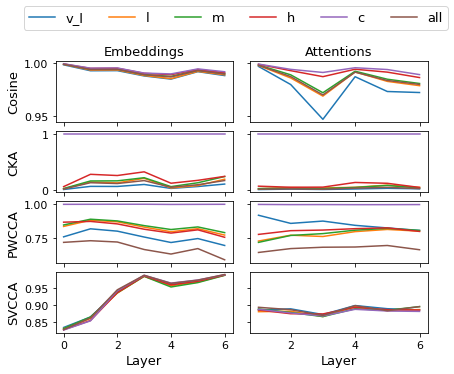

In [726]:
severities = ["v_l", "l", "m", "h","c","all"]
sims_emb = [cosines_c_emb["pt"], ckas_c_emb["pt"], pwccas_c_emb["pt"], svccas_c_emb["pt"]]
sims_att = [cosines_c_att["pt"], ckas_c_att["pt"], pwccas_c_att["pt"], svccas_c_att["pt"]]
title = "comp-hd-pt"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plot_sims_both(sims_emb,sims_att, severities, title)

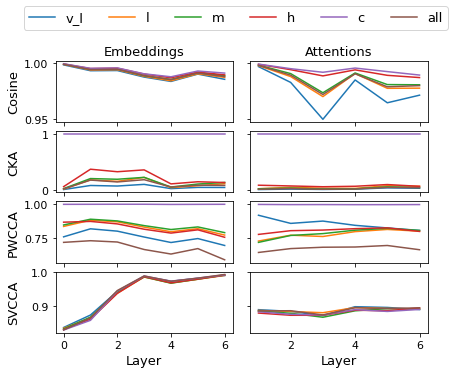

In [727]:
severities = ["v_l", "l", "m", "h","c","all"]
sims_emb = [cosines_c_emb["ft"], ckas_c_emb["ft"], pwccas_c_emb["ft"], svccas_c_emb["ft"]]
sims_att = [cosines_c_att["ft"], ckas_c_att["ft"], pwccas_c_att["ft"], svccas_c_att["ft"]]
title = "comp-hd-ft"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plot_sims_both(sims_emb,sims_att, severities, title)

### Differences in Results to Baseline (Baseline-Normalized Results)

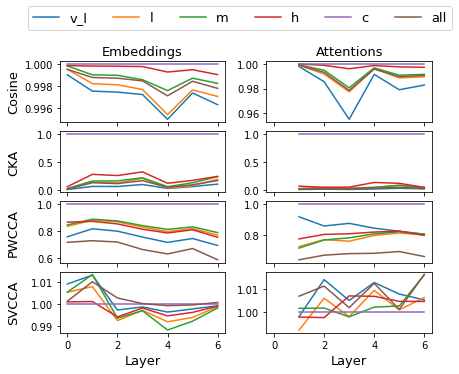

In [800]:
severities = ["v_l", "l", "m", "h","c", "all"]
sims_emb = [cosines_c_emb["pt"], ckas_c_emb["pt"], pwccas_c_emb["pt"], svccas_c_emb["pt"]]
sims_att = [cosines_c_att["pt"], ckas_c_att["pt"], pwccas_c_att["pt"], svccas_c_att["pt"]]
title = "comp-hd-diff2b-pt"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plot_diffs_rel(sims_emb, sims_att,severities, title, c=True)

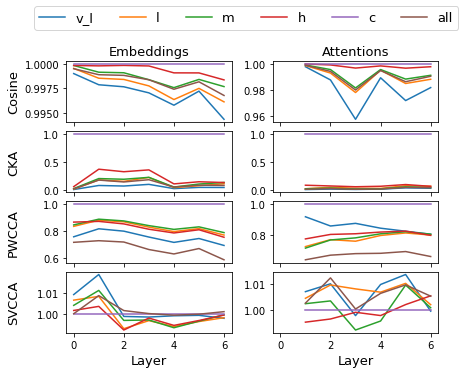

In [25]:
severities = ["v_l", "l", "m", "h","c", "all"]
sims_emb = [cosines_c_emb["ft"], ckas_c_emb["ft"], pwccas_c_emb["ft"], svccas_c_emb["ft"]]
sims_att = [cosines_c_att["ft"], ckas_c_att["ft"], pwccas_c_att["ft"], svccas_c_att["ft"]]
title = "comp-hd-diff2b-ft"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plot_diffs_rel(sims_emb, sims_att,severities, title, c=True)

### What is the trend of the results (differential quotient)?

**Remark**: the differential quotient is calculated by taking the difference of two consecutive values => If there are 7 layers to begin with, we get 6 values => one value indicates the change from one layer to another

In [ ]:
sims_emb_pt = [cosines_c_emb["pt"], ckas_c_emb["pt"], pwccas_c_emb["pt"], svccas_c_emb["pt"]]
sims_emb_ft = [cosines_c_emb["ft"], ckas_c_emb["ft"], pwccas_c_emb["ft"], svccas_c_emb["ft"]]
sims_att_pt = [cosines_c_att["pt"], ckas_c_att["pt"], pwccas_c_att["pt"], svccas_c_att["pt"]]
sims_att_ft = [cosines_c_att["ft"], ckas_c_att["ft"], pwccas_c_att["ft"], svccas_c_att["ft"]]

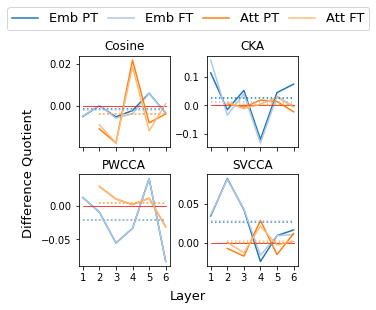

In [1262]:
diffs_emb_pt, diffs_mean_emb_pt = get_diffquots(sims_emb_pt)
diffs_emb_ft, diffs_mean_emb_ft = get_diffquots(sims_emb_ft)
diffs_att_pt, diffs_mean_att_pt = get_diffquots(sims_att_pt)
diffs_att_ft, diffs_mean_att_ft = get_diffquots(sims_att_ft)

metrics = ["Cosine","CKA","PWCCA","SVCCA"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
title="h_vs_d_trend"
plot_diff_quots_ptft_both(diffs_emb_pt,diffs_emb_ft,diffs_att_pt,diffs_att_ft,diffs_mean_emb_pt,diffs_mean_emb_ft,diffs_mean_att_pt,diffs_mean_att_ft, metrics,title)

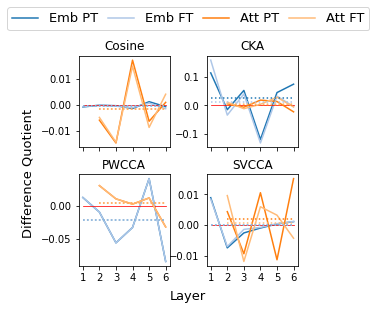

In [1261]:
diffs_emb_pt_b, diffs_mean_emb_pt_b = get_diffquots(sims_emb_pt,baseline=True,c=True)
diffs_emb_ft_b, diffs_mean_emb_ft_b = get_diffquots(sims_emb_ft,baseline=True,c=True)
diffs_att_pt_b, diffs_mean_att_pt_b = get_diffquots(sims_att_pt,baseline=True,c=True)
diffs_att_ft_b, diffs_mean_att_ft_b = get_diffquots(sims_att_ft,baseline=True,c=True)

metrics = ["Cosine","CKA","PWCCA","SVCCA"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
title="h_vs_d_trend_b"
plot_diff_quots_ptft_both(diffs_emb_pt_b,diffs_emb_ft_b,diffs_att_pt_b,diffs_att_ft_b,diffs_mean_emb_pt_b,diffs_mean_emb_ft_b,diffs_mean_att_pt_b,diffs_mean_att_ft_b, metrics,title)

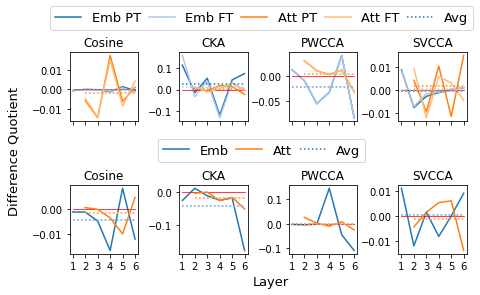

In [ ]:
metrics = ["Cosine","CKA","PWCCA","SVCCA"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
title="diffquots_b"
plot_diff_quots_ptft_both2([diffs_emb_b,diffs_emb_pt_b],[diffs_emb_b,diffs_emb_ft_b],[diffs_att_b,diffs_att_pt_b],[diffs_att_b,diffs_att_ft_b],[diffs_mean_emb_b,diffs_mean_emb_pt_b],[diffs_mean_emb_b,diffs_mean_emb_ft_b],[diffs_mean_att_b,diffs_mean_att_pt_b],[diffs_mean_att_b,diffs_mean_att_ft_b], metrics,title)

### How much does the ranking correlate with the expected ranking?

In [ ]:
metrics = ["Cosine","CKA","PWCCA","SVCCA"]

n_layers=7
kendalltaus_emb_pt = calc_kendalltaus(sims_emb_pt,metrics,n_layers)
kendalltaus_emb_ft = calc_kendalltaus(sims_emb_ft,metrics,n_layers)
kendalltaus_emb_pt_b = calc_kendalltaus(sims_emb_pt,metrics,n_layers,baseline=True,c=True)
kendalltaus_emb_ft_b = calc_kendalltaus(sims_emb_ft,metrics,n_layers,baseline=True,c=True)

n_layers=6
kendalltaus_att_pt = calc_kendalltaus(sims_att_pt,metrics,n_layers)
kendalltaus_att_ft = calc_kendalltaus(sims_att_ft,metrics,n_layers)
kendalltaus_att_pt_b = calc_kendalltaus(sims_att_pt,metrics,n_layers,baseline=True,c=True)
kendalltaus_att_ft_b = calc_kendalltaus(sims_att_ft,metrics,n_layers,baseline=True,c=True)


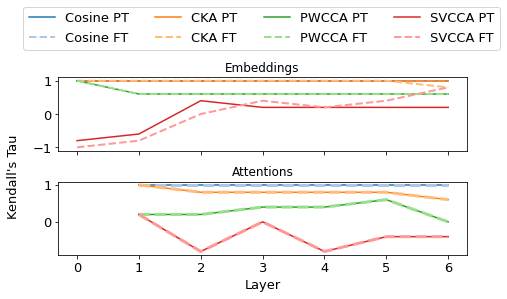

In [844]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
title="h_vs_d_rank_correlation"
plot_kendalltaus_ptft_both(kendalltaus_emb_pt,kendalltaus_emb_ft,kendalltaus_att_pt,kendalltaus_att_ft,title)

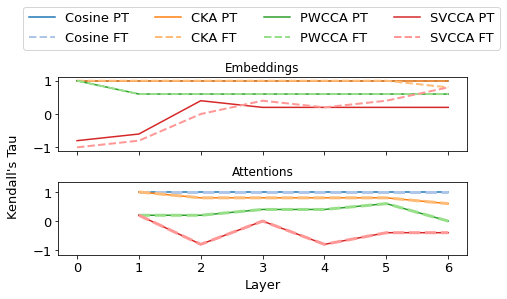

In [1155]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
title="h_vs_d_rank_correlation_b"
plot_kendalltaus_ptft_both(kendalltaus_emb_pt_b,kendalltaus_emb_ft_b,kendalltaus_att_pt_b,kendalltaus_att_ft_b,title)

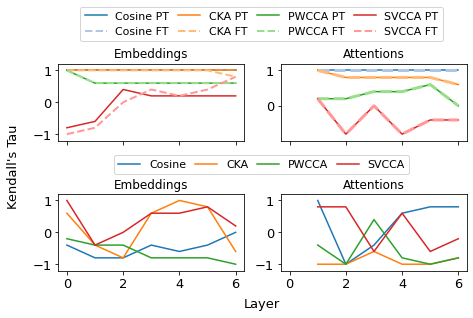

In [1150]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
title="rank_correlation_b"
#plot_kendalltaus_ptft_both2([kendalltaus_emb_b, kendalltaus_emb_pt_b],[kendalltaus_emb_b,kendalltaus_emb_ft_b],[kendalltaus_att_b,kendalltaus_att_pt_b],[kendalltaus_att_b,kendalltaus_att_ft_b],title)
plot_kendalltaus_ptft_both2([kendalltaus_emb_pt_b, kendalltaus_emb_b],[kendalltaus_emb_ft_b,kendalltaus_emb_b],[kendalltaus_att_pt_b,kendalltaus_att_b],[kendalltaus_att_ft_b,kendalltaus_att_b],title)

# PT vs. FT

In [164]:
cosines_emb = load_pkl('sims/cosines_tavg_ptft.pkl')
ckas_emb = load_pkl('sims/ckas_tavg_ptft.pkl')
pwccas_emb = load_pkl('sims/pwccas_tavg_ptft.pkl')
svccas_emb = load_pkl('sims/svccas_tavg_ptft.pkl')

cosines_att = load_pkl('sims/cosines_attentions_ptft.pkl')
ckas_att = load_pkl('sims/ckas_attentions_ptft.pkl')
pwccas_att = load_pkl('sims/pwccas_attentions_ptft.pkl')
svccas_att = load_pkl('sims/svccas_attentions_ptft.pkl')

### Basic Results

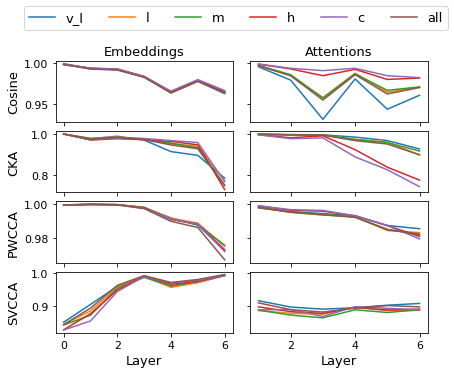

In [1061]:
severities = ["v_l", "l", "m", "h","c","all"]
sims_emb = [cosines_emb, ckas_emb, pwccas_emb, svccas_emb]
sims_att = [cosines_att, ckas_att, pwccas_att, svccas_att]
title = "comp-ptft"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plot_sims_both(sims_emb,sims_att, severities, title)

### Differences in Results to Baseline (Baseline-Normalized Results)

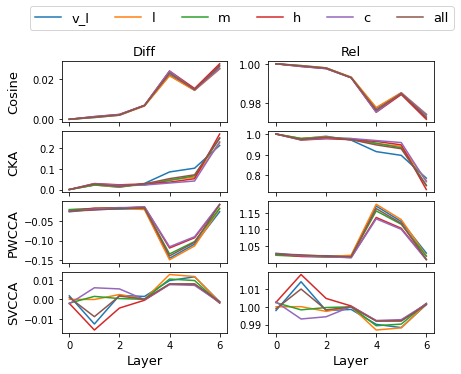

In [742]:
severities = ["v_l", "l", "m", "h","c", "all"]
sims = [cosines_emb, ckas_emb, pwccas_emb, svccas_emb]
title = "comp-ptft-diff2b-emb"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plot_diffs_both(sims, severities, title, c=False, emb_att="emb")

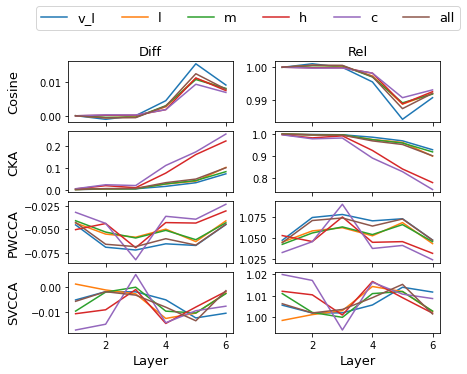

In [743]:
severities = ["v_l", "l", "m", "h","c", "all"]
sims = [cosines_att, ckas_att, pwccas_att, svccas_att]
title = "comp-ptft-diff2b-att"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plot_diffs_both(sims, severities, title, c=False, emb_att="att")

### What is the trend of the results (difference quotient)?

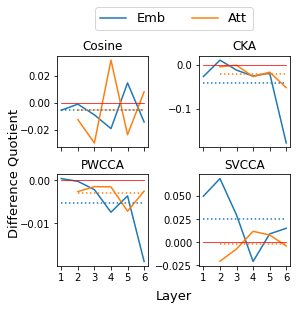

In [1285]:
diffs_emb, diffs_mean_emb = get_diffquots(sims_emb)
diffs_emb_b, diffs_mean_emb_b = get_diffquots(sims_emb, baseline=True)
diffs_att, diffs_mean_att = get_diffquots(sims_att)
diffs_att_b, diffs_mean_att_b = get_diffquots(sims_att, baseline=True)

metrics = ["Cosine","CKA","PWCCA","SVCCA"]

# Difference quotients for basic results
title="pt_vs_ft_trend"
plot_diff_quots_both(diffs_emb,diffs_mean_emb,diffs_att,diffs_mean_att,metrics,title)

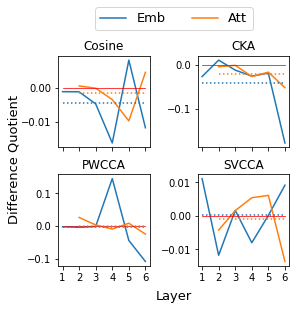

In [1287]:
# Difference quotients for baseline-normalized results
title="pt_vs_ft_trend_b"
plot_diff_quots_both(diffs_emb_b,diffs_mean_emb_b,diffs_att_b,diffs_mean_att_b,metrics,title)

### How much does the ranking correlate with the expected ranking?

In [1066]:
sims_emb = [cosines_emb, ckas_emb, pwccas_emb, svccas_emb]
sims_att = [cosines_att, ckas_att, pwccas_att, svccas_att]
metrics = ["Cosine","CKA","PWCCA","SVCCA"]

n_layers=7
kendalltaus_emb = calc_kendalltaus(sims_emb,metrics,n_layers)
kendalltaus_emb_b = calc_kendalltaus(sims_emb,metrics,n_layers,baseline=True)

n_layers=6
kendalltaus_att = calc_kendalltaus(sims_att,metrics,n_layers)
kendalltaus_att_b = calc_kendalltaus(sims_att,metrics,n_layers,baseline=True)

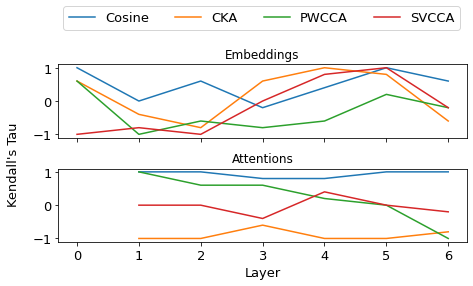

In [827]:
# trend for basic result
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
title="pt_vs_ft_rank_correlation"
plot_kendalltaus_both(kendalltaus_emb,kendalltaus_att,title)

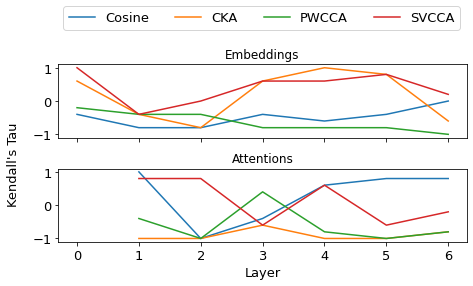

In [1156]:
# trend for baseline-normalized results  
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
title="pt_vs_ft_rank_correlation_b"
plot_kendalltaus_both(kendalltaus_emb_b,kendalltaus_att_b,title)